# Autoencoders for Image Denoising

- Will create a vanilla autoencoder and a convolutional autoencoder for image denoising</br>
- The MNIST dataset will be used, noise will be added to input images and output will be compared to original images.
</br></br>

### Import Data and Libraries
---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
LEARNING_RATE = 3e-3
EPOCHS = 5
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NOISE_FACTOR = 0.06

</br></br>

### Basic Data Preprocessing
---

- Import original MNIST train and test datasets
- Convert dataset to tensors

In [24]:
train_data_df = pd.read_csv("train_data.csv")
test_data_df = pd.read_csv("test_data.csv")

In [25]:
train_data_df.drop(['Unnamed: 0', 'Y'], axis=1, inplace=True)
test_data_df.drop(['Unnamed: 0', 'Y'], axis=1, inplace=True)

In [26]:
train_data_tensor = torch.tensor(train_data_df.to_numpy(), dtype=float)
test_data_tensor = torch.tensor(test_data_df.to_numpy(), dtype=float)

train_data_tensor /= 255.0
test_data_tensor /= 255.0

In [27]:
train_data_tensor.shape, test_data_tensor.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

</br></br>

### Visualize Images and Noisy Images
---

- Plot original images
- Plot noisy images

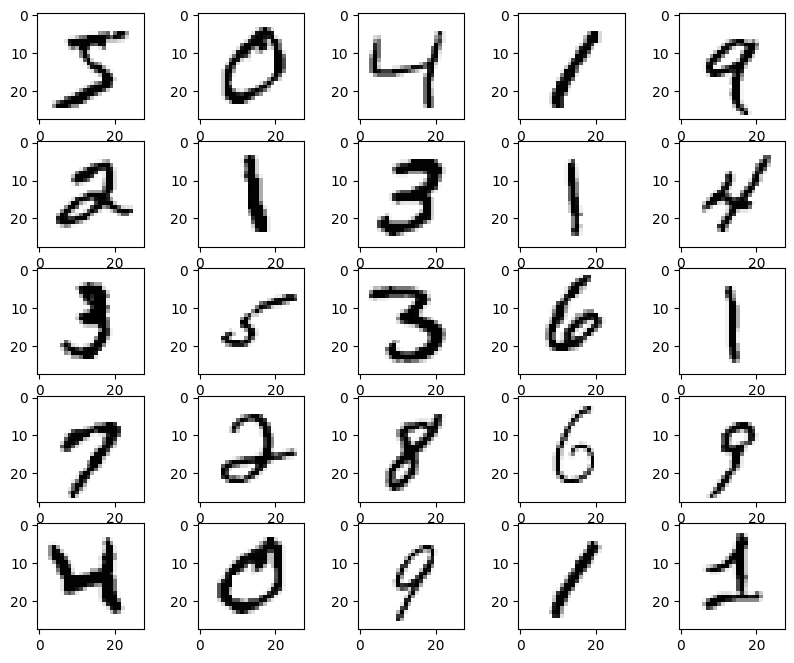

In [28]:
plt.figure(figsize=(10, 8))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_data_tensor[i].view((28, 28)), cmap='Greys');

</br>

Noise is added to input images by random small values to each of the pixel values in the original input. A hyperparameter for noise factor is multiplied by the random values to further affect the strength of the noise added to the images.

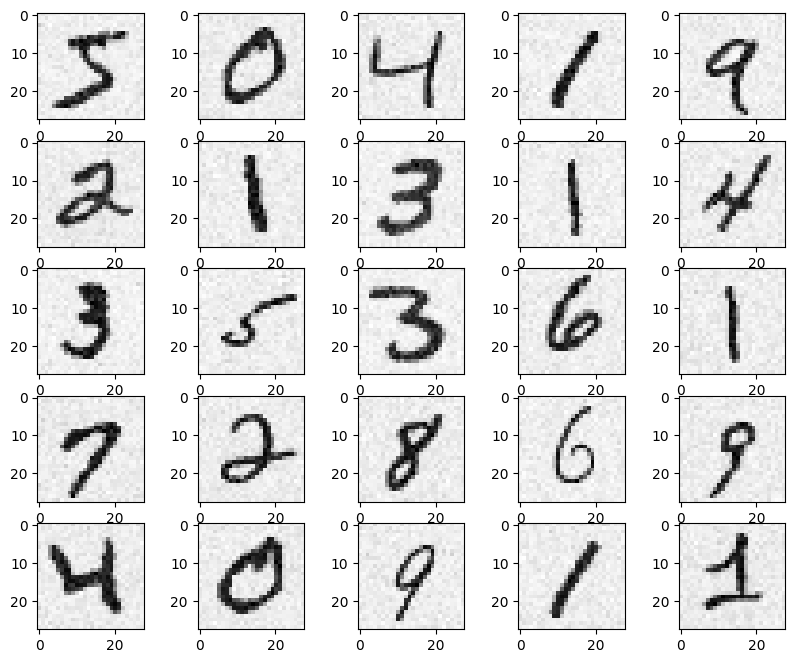

In [29]:
plt.figure(figsize=(10, 8))

for i in range(25):
    # Add noise to input image
    noise = NOISE_FACTOR * torch.randn_like(train_data_tensor[i])
    noisy_input = train_data_tensor[i] + noise
    noisy_input = noisy_input.view((28, 28))

    # Plot resulting image
    plt.subplot(5, 5, i + 1)
    plt.imshow(noisy_input, cmap='Greys');

</br></br>

### Data Preperation
---
- Create Dataset class for MNIST images
- Train/test split
- Generate Batches and shuffle

In [31]:
class MnistDataset(Dataset):
    def __init__(self, data):
        self.x = data + (NOISE_FACTOR * torch.randn_like(data))
        self.y = data

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [32]:
train_data = DataLoader(MnistDataset(train_data_tensor), batch_size=BATCH_SIZE, shuffle=True)
test_data  = DataLoader(MnistDataset(test_data_tensor),  batch_size=BATCH_SIZE, shuffle=True)

</br></br>

### Create Vanilla Autoencoder Architecture
---

Autoencoders function by through a encoder model and a decoder model. The encoder projects the original input to a much more lower dimensional space. This allows the encoder to learn a much more compact latent representation of the original input that still contains most of the information to describe the original data. This is useful for dimensionality reduction, and data compression. The decoder model tries to take this encoded representation of the input and reconstruct the original input.

</br>

For denoising autoencoders, the input to the encoder model is the noisy image, and the decoder tries to reconstruct the non-noisy version of the input image from the encoded input. Ultimately, the encoder learns to best capture the important features from the original input to include in the encoded representation, and the decoder learns to ignore the information corresponding to noise present in the latent representation.

</br>

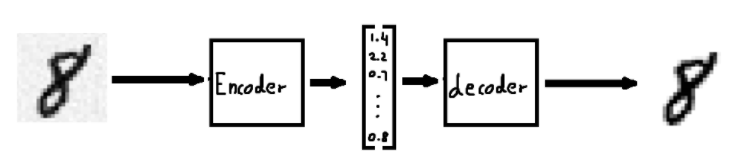![](image.png)

</br>

`AutoEncoder`
- Encoder: Consists of linear layers which project the input to a lower dimension, followed by batchnorm for normalization, and relu nonlinearity, input transfoms from 256 -> 64 -> 8
- Decoder: Consists of similar architecture as encoder but performs opposite input transformations to reconstruct the original image, 8 -> 64 -> 256


</br>

In [57]:
class AutoEncoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 8),
            nn.BatchNorm1d(8),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, in_dim),
            nn.BatchNorm1d(in_dim),
            nn.Sigmoid()
        )


    def forward(self, x):
        # Flatten input
        x = x.view((BATCH_SIZE, -1))

        x = self.encoder(x)
        x = self.decoder(x)

        return x

</br></br>

### Create Convolutional Autoencoder Architecture
---

Convolutional autoencoders reduce the dimensions of the input image progressively, while increasing the number of channels corresponding to each compressed image. This is to compensate for the information loss that occurs when the dimensions of the input image are compressed. Additionally, increasing the channel size at each convolutional layer enables the network to focus more on hierarchical features in the deeper layers. Will create the following architecture:

</br>

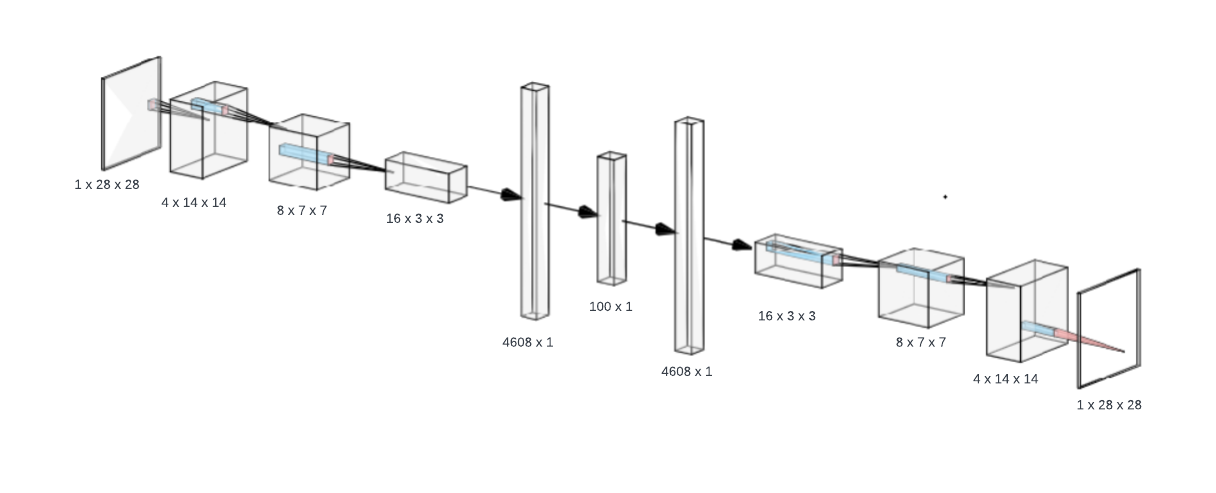![](image2.png)

</br>

`Convolutional Autoencoder`
- Encoder:
    - Consists of convolutional layers to extract high level features and to create channels in order to preserve information
    - 2D Batchnormalization layers that normalize the preactivation input for the particular batch
    - ReLU nonlinearity is used, along with maxpooling at the end to reduce the size of the input
    - Finally flattens the output and projects it to a 100 dimensional latent space
- Decoder:
    - Reconstructs original denoised image from the 100 length vector
    - Performs opposite transformations as encoder through transposed convolutions
    - Tanh at the end to convert to pixel values



In [99]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self, in_dim=None):
      super().__init__()

      self.enc_block_1 = nn.Sequential(
          nn.Conv2d(1, 4, 3, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
      )
      self.enc_block_2 = nn.Sequential(
          nn.Conv2d(4, 8, 3, padding=1),
          nn.BatchNorm2d(8),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
      )
      self.enc_block_3 = nn.Sequential(
          nn.Conv2d(8, 16, 3, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
      )

      self.ln1 = nn.Linear(144, 10)
      self.ln2 = nn.Linear(10, 144)

      self.dec_block_1 = nn.Sequential(
          nn.ConvTranspose2d(16, 8, 3, stride=2),
          nn.BatchNorm2d(8),
          nn.ReLU()
      )
      self.dec_block_2 = nn.Sequential(
          nn.ConvTranspose2d(8, 4, 2, stride=2),
          nn.BatchNorm2d(4),
          nn.ReLU()
      )
      self.dec_block_3 = nn.Sequential(
          nn.ConvTranspose2d(4, 1, 2, stride=2),
          nn.Sigmoid()
      )


    def forward(self, x):
      x = self.enc_block_1(x)
      x = self.enc_block_2(x)
      x = self.enc_block_3(x)

      x = x.view((32, -1))
      x = self.ln1(x)

      x = self.ln2(x)
      x = x.view((32, 16, 3, 3))

      x = self.dec_block_1(x)
      x = self.dec_block_2(x)
      x = self.dec_block_3(x)

      return x

</br></br>

### Create Training Functions
---

In [95]:
def train_epoch(model, optim, train_data):
    lossi = []

    # Disregard batches of non-BATCH_SIZE size
    for x,y in train_data:
      if x.shape[0] != BATCH_SIZE:
        continue

      # View inputs as 28 x 28 images
      x = x.view((BATCH_SIZE, 1, 28, 28))
      x, y = x.float().to(DEVICE), y.to(DEVICE)

      # Forward Pass, MSE loss
      output = model(x).view(BATCH_SIZE, -1)
      loss = ((output - y) ** 2).mean()

      # Backward Pass
      optim.zero_grad()
      loss.backward()
      optim.step()

      # Track Stats
      lossi.append(loss.item())

    return torch.tensor(lossi).mean()


@torch.no_grad()
def test_epoch(model, test_data):
    lossi = []

    # Disregard batches of non-BATCH_SIZE size
    for x,y in test_data:
      if x.shape[0] != BATCH_SIZE:
        continue

      # View inputs as 28 x 28 images
      x = x.view((BATCH_SIZE, 1, 28, 28))
      x, y = x.float().to(DEVICE), y.to(DEVICE)

      # Forward Pass, MSE loss
      output = model(x).view(BATCH_SIZE, 1, -1)
      loss = ((output - y) ** 2).mean()

      # Track Stats
      lossi.append(loss.item())

    return torch.tensor(lossi).mean()

</br></br>

### Train and Evaluate AutoEncoders
---

In [128]:
vanilla_autoencoder = AutoEncoder(784).to(DEVICE)
optim = torch.optim.AdamW(vanilla_autoencoder.parameters(),
                                          lr=LEARNING_RATE)

conv_autoencoder = ConvolutionalAutoEncoder(784).to(DEVICE)
optim_conv = torch.optim.AdamW(conv_autoencoder.parameters(),
                                            lr=LEARNING_RATE)

In [129]:
losses = []
for epoch in range(EPOCHS):
    train_loss = train_epoch(vanilla_autoencoder, optim, train_data)
    test_loss = test_epoch(vanilla_autoencoder, test_data)
    losses.append([train_loss.item(), test_loss.item()])

    print(f"EPOCH: {epoch} | TRAIN_LOSS: {train_loss.item()} | TEST_LOSS: {test_loss.item()}")

EPOCH: 0 | TRAIN_LOSS: 0.08477254211902618 | TEST_LOSS: 0.1178993433713913
EPOCH: 1 | TRAIN_LOSS: 0.04148370027542114 | TEST_LOSS: 0.10001003742218018
EPOCH: 2 | TRAIN_LOSS: 0.03333563730120659 | TEST_LOSS: 0.10202392935752869
EPOCH: 3 | TRAIN_LOSS: 0.03033815696835518 | TEST_LOSS: 0.10465598851442337
EPOCH: 4 | TRAIN_LOSS: 0.027872230857610703 | TEST_LOSS: 0.10699068009853363


In [130]:
losses_conv = []
for epoch in range(EPOCHS):
    train_loss = train_epoch(conv_autoencoder, optim_conv, train_data)
    test_loss = test_epoch(conv_autoencoder, test_data)
    losses_conv.append([train_loss.item(), test_loss.item()])

    print(f"EPOCH: {epoch} | TRAIN_LOSS: {train_loss.item()} | TEST_LOSS: {test_loss.item()}")

EPOCH: 0 | TRAIN_LOSS: 0.0363285057246685 | TEST_LOSS: 0.10651201754808426
EPOCH: 1 | TRAIN_LOSS: 0.02570917084813118 | TEST_LOSS: 0.10817520320415497
EPOCH: 2 | TRAIN_LOSS: 0.024854160845279694 | TEST_LOSS: 0.1080804243683815
EPOCH: 3 | TRAIN_LOSS: 0.02442377246916294 | TEST_LOSS: 0.10587436705827713
EPOCH: 4 | TRAIN_LOSS: 0.02414216473698616 | TEST_LOSS: 0.10846906900405884


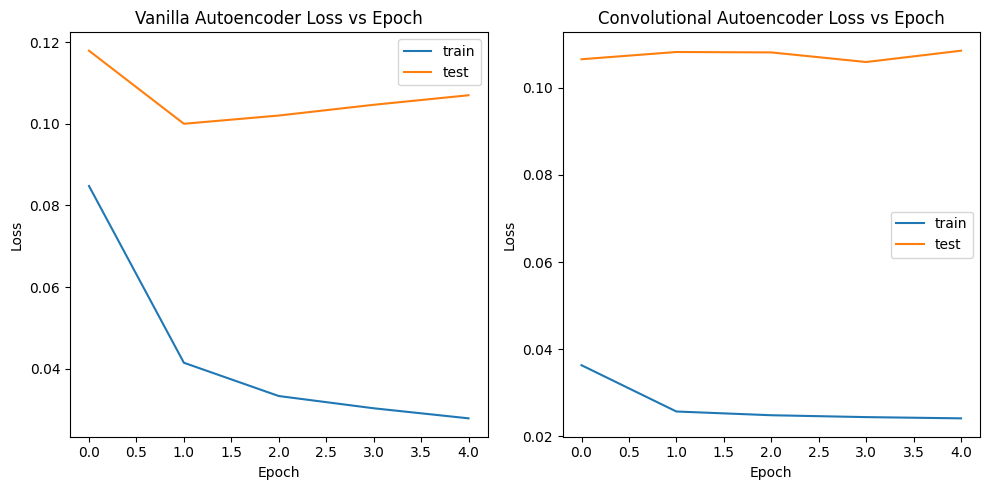

In [135]:
train_losses = torch.tensor(losses)[:,0]
test_losses  = torch.tensor(losses)[:,1]

train_losses_conv = torch.tensor(losses_conv)[:,0]
test_losses_conv  = torch.tensor(losses_conv)[:,1]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses.detach().cpu().numpy(), label='train')
plt.plot(test_losses.detach().cpu().numpy(),  label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Vanilla Autoencoder Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_conv.detach().cpu().numpy(), label='train')
plt.plot(test_losses_conv.detach().cpu().numpy(),  label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Convolutional Autoencoder Loss vs Epoch")
plt.legend()

plt.tight_layout();

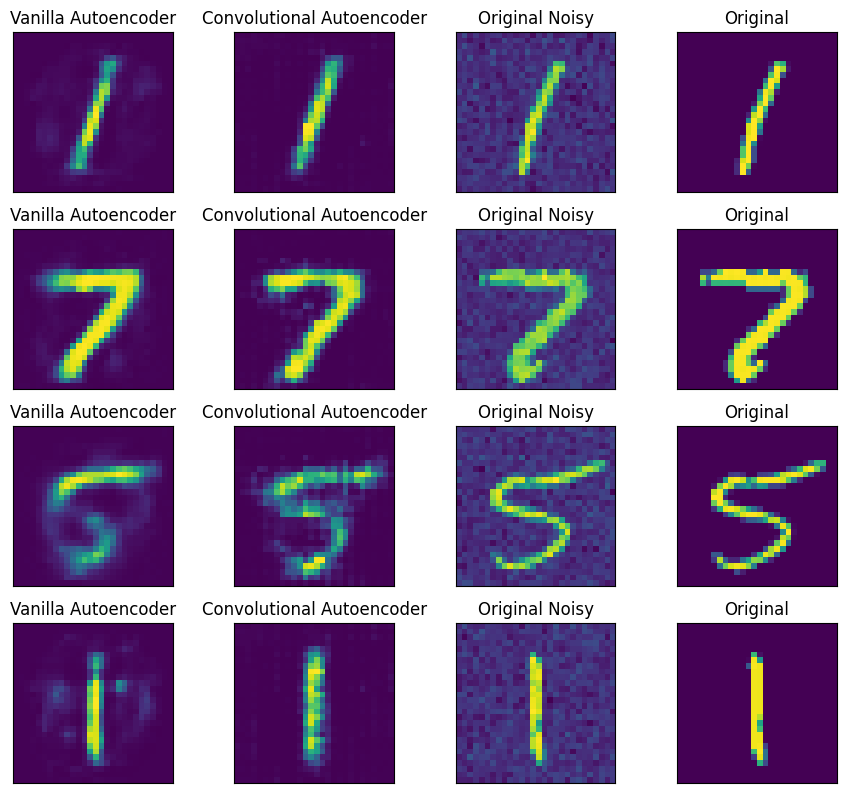

In [154]:
with torch.no_grad():
  plt.figure(figsize=(9, 10))
  c = 15
  plots = 1
  for i, (x,y) in enumerate(test_data):
      input = x.float().view((32, 1, 28, 28)).to(DEVICE)
      vanilla_output = vanilla_autoencoder(input)
      conv_output    = conv_autoencoder(input)

      plt.subplot(c // 3, 4, plots)
      plt.imshow(vanilla_output[0].view((28, 28)).cpu().detach().numpy())
      plt.title("Vanilla Autoencoder")
      plt.xticks([])
      plt.yticks([])

      plt.subplot(c // 3, 4, plots + 1)
      plt.imshow(conv_output[0].view((28, 28)).cpu().detach().numpy())
      plt.title("Convolutional Autoencoder")
      plt.xticks([])
      plt.yticks([])

      plt.subplot(c // 3, 4, plots + 2)
      plt.imshow(x[0].view((28, 28)).detach().numpy())
      plt.title("Original Noisy")
      plt.xticks([])
      plt.yticks([])

      plt.subplot(c // 3, 4, plots + 3)
      plt.imshow(y[0].view((28, 28)).detach().numpy())
      plt.title("Original")
      plt.xticks([])
      plt.yticks([])

      plots += 4
      if plots >= c:
          break


plt.tight_layout()